# Fully unsupervised dynamic MRI reconstruction via geometrotemporal equivariance

[Paper](https://arxiv.org/abs/2410.08646) | [Repo](https://github.com/Andrewwango/ddei) | [Website](https://andrewwango.github.io/ddei)

![](img/demo_results.gif)

**Aim**: reconstruct dynamic MRI videos from accelerated undersampled measurements $\mathbf{y}=\mathbf{Ax}$ where $\mathbf{A}$ is an undersampled Fourier operator.

**Applications**: real-time cardiac imaging, free-breathing motion, vocal tract speech...

**Goals**:

- Capture true motion: aperiodicities, irregularities: real-time MRI
- Capture higher spatiotemporal resolution with fewer measurements (leading to faster, cheaper, portable MRI)

**Why is it hard?** ground truth is impossible to truly obtain! There is no such thing as true fully-sampled dynamic MRI data at the same frame rate as the measurement data. Hence all supervised methods ([CineNet](https://aapm.onlinelibrary.wiley.com/doi/10.1002/mp.14809), [transformers](https://link.springer.com/chapter/10.1007/978-3-031-52448-6_39)...) are fundamentally flawed - an implicit [_data crime_](https://www.pnas.org/doi/full/10.1073/pnas.2117203119). The best pseudo-ground-truth, e.g. gating/cine imaging, must assume periodicity and all methods that use this cannot capture true motion and its irregularities - which is often of interest in medical imaging. Therefore we need unsupervised methods.

**Our method** we posit that the unknown set $\mathcal{X}$ of MRI videos is $G$-invariant: $\forall x\in\mathcal{X},g\cdot x\in\mathcal{X}\forall g\in G$. We propose a spatiotemporal group combining temporal invariance and diffeomorphic invariance: see our paper for more details. We use the [Equivariant Imaging](https://openaccess.thecvf.com/content/ICCV2021/papers/Chen_Equivariant_Imaging_Learning_Beyond_the_Range_Space_ICCV_2021_paper.pdf) framework to constrain this with a ground-truth-free loss, which we call **D**ynamic **D**iffeomorphic **E**quivariant **I**maging (**DDEI**).

**Results**: see [below](#full-results).

You can easily implement our method using the [`deepinv`](https://deepinv.github.io) library. See [train.py](train.py) for a full training demo including training and evaluating competitors. Contents:

1. [Define physics](#define-dynamic-mri-physics)
2. [Define DDEI loss](#define-the-ddei-loss-function)
3. [Define data](#define-the-data)
4. [Define network](#define-neural-network)
5. [Train model](#train-the-network)
6. [Test pretrained model](#test-a-pretrained-model)

In [ ]:
import torch
from torch.utils.data import DataLoader

import deepinv as dinv

from utils import Trainer, ArtifactRemovalCRNN, CRNN, DeepinvSliceDataset, CineNetDataTransform

### Define dynamic MRI physics:

Define accelerated dynamic MRI. We set the (4x, 8x, 16x) undersampling mask on-the-fly as it varies per subject.

In [2]:
physics = dinv.physics.DynamicMRI(img_size=(1, 2, 12, 512, 256), device="cpu")

### Define the DDEI loss function:

See [train.py](train.py) for full demo of how to train with competitors' losses using [`deepinv`](https://deepinv.github.io).

In [ ]:
transform = dinv.transform.ShiftTime() | (dinv.transform.CPABDiffeomorphism() | dinv.transform.Rotate())
loss = [dinv.loss.MCLoss(), dinv.loss.EILoss(transform=transform)]

### Define the data:

We use a real-world cardiac 2D+t dataset from the [2023 CMRxRecon challenge](https://cmrxrecon.github.io/). This dataset has fully-sampled cine measurements which we use as GT for evaluation, but we emphasise our method does not require gated GT for training. We then simulate 2D+t random Cartesian undersampling masks using [`deepinv`](https://deepinv.github.io), see [this notebook](https://andrewwango.github.io/ddei/data/prepare_masks) for more details. For more details on how to download the full dataset see [README](README.md).

In [7]:
dataset = DeepinvSliceDataset(
    root="data/CMRxRecon",
    transform=CineNetDataTransform(time_window=12, apply_mask=True, normalize=True), 
    set_name="TrainingSet",
    acc_folders=["FullSample"],
    mask_folder="TimeVaryingGaussianMask08",
    dataset_cache_file="cache.pkl"
)
loader = DataLoader(dataset=dataset)

100%|██████████| 1/1 [00:00<00:00,  4.81it/s]

Saving dataset cache file


### Define neural network:

For $f_\theta$ we use a very small [CRNN](https://ieeexplore.ieee.org/document/8425639), a lightweight unrolled network with 2 unrolled iterations and 1154 parameters. Our framework is **NN-agnostic** and any state-of-the-art NN can be used as the backbone.

In [8]:
model = ArtifactRemovalCRNN(CRNN(num_cascades=2)).to("cpu")

### Train the network!

We train the network using a modified [`deepinv.Trainer`](https://deepinv.github.io/deepinv/stubs/deepinv.Trainer.html). For full training demo, see [train.py](train.py).

In [ ]:
trainer = Trainer(
    model = model,
    physics = physics,
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3),
    train_dataloader = loader,
    losses = loss,
    metrics = dinv.metric.PSNR(complex_abs=True, max_pixel=None)
)

trainer.train()

### Test a pretrained model

We load the model used for the paper trained with 50 epochs on our full train set, provided in `models/`. Test on a sample image included locally and compare to the initial zero-filled reconstruction.

In [12]:
model.load_state_dict(torch.load("models/ddei_pretrained_50.pth.tar", map_location="cpu")["state_dict"])

<All keys matched successfully>

In [19]:
x, y, mask = next(iter(loader))
physics.update_parameters(mask=mask)
x_hat = model(y, physics)
x_zf = physics.A_adjoint(y)

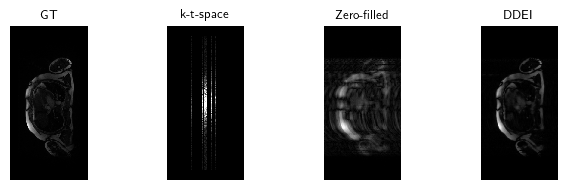

In [21]:
dinv.utils.plot_videos([x, y.clip(-2, 2), x_zf, x_hat], titles=["GT", "k-t-space", "Zero-filled", "DDEI"], display=True)

### Full results

Test set example cardiac long axis views (above 2 rows) and short axis slice (below) reconstruction results:

![](img/results_fig_1.gif)